In [1]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import keras 

Segmentation Models: using `tf.keras` framework.


In [3]:
#from keras.utils import normalize
from keras.utils.np_utils import normalize
from keras.metrics import MeanIoU

In [4]:
#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
#n_classes=5

In [5]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("indoor_data/Images_128"):
    for img_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        img = cv2.imread(img_path, 1)       
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [6]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("indoor_data/Masks_128"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.tiff")):
        mask = cv2.imread(mask_path, 0)       
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [7]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [8]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [9]:
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, shuffle=True, random_state = 42)

#Further split training data to a smaller subset for quick training
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.5, shuffle=True, random_state = 42)

print("Class values in the dataset are ... ", np.unique(y_train))

Class values in the dataset are ...  [0 1 2 3 4 5 6 7 8 9]


In [10]:
from keras.utils.np_utils import to_categorical

n_classes=10

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [11]:
#Reused parameters in all models

n_classes=10
activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

#dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

#Total_loss can be imported directly from library
total_loss = sm.losses.binary_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [12]:
#ResNet-34
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

In [13]:
#Preprocess input
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [14]:
#Define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

In [15]:
#Compile keras model with defined optimozer, loss and metrics
model1.compile(optim, total_loss, metrics=metrics)

In [16]:
print(model1.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [16]:
history1=model1.fit(X_train1, 
          y_train_cat,
          #batch_size=8,
          #batch_size=16,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(X_test1, y_test_cat))

Epoch 1/50
22/22 [==============================] - 71s 3s/step - loss: 0.9877 - iou_score: 0.0335 - f1-score: 0.0446 - val_loss: 1.0407 - val_iou_score: 0.0056 - val_f1-score: 0.0107
Epoch 2/50
22/22 [==============================] - 65s 3s/step - loss: 0.9372 - iou_score: 0.0841 - f1-score: 0.1028 - val_loss: 0.9652 - val_iou_score: 0.0567 - val_f1-score: 0.0805
Epoch 3/50
22/22 [==============================] - 66s 3s/step - loss: 0.8964 - iou_score: 0.1210 - f1-score: 0.1474 - val_loss: 0.9421 - val_iou_score: 0.0622 - val_f1-score: 0.0867
Epoch 4/50
22/22 [==============================] - 66s 3s/step - loss: 0.8555 - iou_score: 0.1631 - f1-score: 0.2046 - val_loss: 0.9214 - val_iou_score: 0.0603 - val_f1-score: 0.0938
Epoch 5/50
22/22 [==============================] - 67s 3s/step - loss: 0.8183 - iou_score: 0.2460 - f1-score: 0.3003 - val_loss: 0.8808 - val_iou_score: 0.1209 - val_f1-score: 0.1722
Epoch 6/50
22/22 [==============================] - 66s 3s/step - loss: 0.7871 -

22/22 [==============================] - 66s 3s/step - loss: 0.3684 - iou_score: 0.5775 - f1-score: 0.6711 - val_loss: 0.4554 - val_iou_score: 0.5034 - val_f1-score: 0.6034
Epoch 46/50
22/22 [==============================] - 68s 3s/step - loss: 0.3618 - iou_score: 0.5806 - f1-score: 0.6745 - val_loss: 0.4475 - val_iou_score: 0.5113 - val_f1-score: 0.6092
Epoch 47/50
22/22 [==============================] - 66s 3s/step - loss: 0.3608 - iou_score: 0.5803 - f1-score: 0.6761 - val_loss: 0.4422 - val_iou_score: 0.5101 - val_f1-score: 0.6109
Epoch 48/50
22/22 [==============================] - 66s 3s/step - loss: 0.3641 - iou_score: 0.5776 - f1-score: 0.6708 - val_loss: 0.4433 - val_iou_score: 0.5125 - val_f1-score: 0.6113
Epoch 49/50
22/22 [==============================] - 65s 3s/step - loss: 0.3681 - iou_score: 0.5721 - f1-score: 0.6700 - val_loss: 0.4333 - val_iou_score: 0.5184 - val_f1-score: 0.6156
Epoch 50/50
22/22 [==============================] - 66s 3s/step - loss: 0.3615 - iou_s

In [17]:
model1.save('res34_backbone_50epochs_32_indoor_f5.hdf5')

C:\Users\user\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Batch 8 - plots

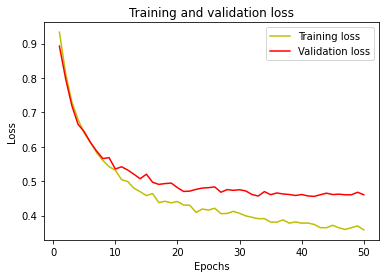

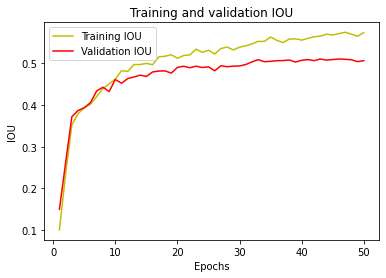

In [22]:
#Fold-1
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

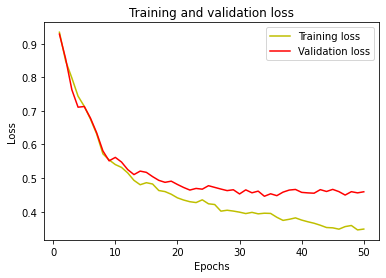

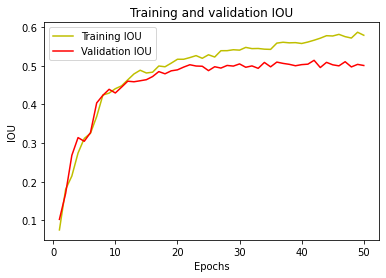

In [22]:
#Fold-2
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

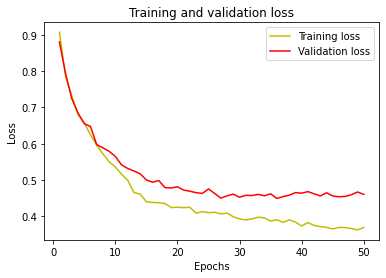

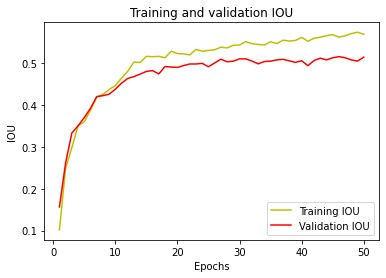

In [18]:
#Fold-3
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

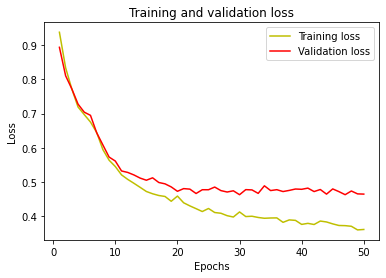

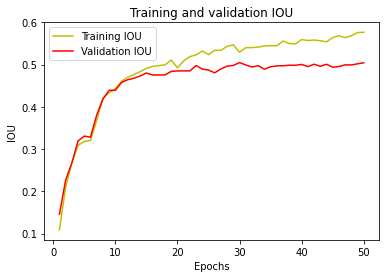

In [26]:
#Fold-4
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

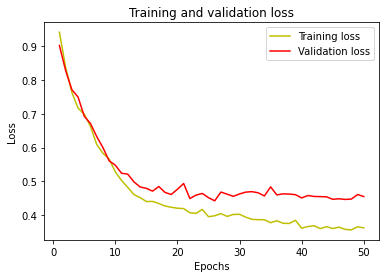

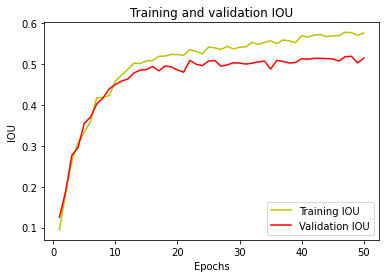

In [23]:
#Fold-5
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Batch 16 - plots

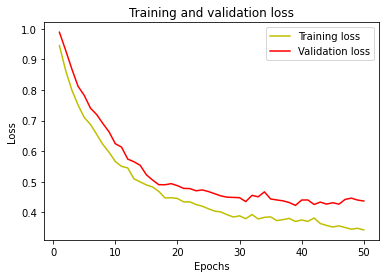

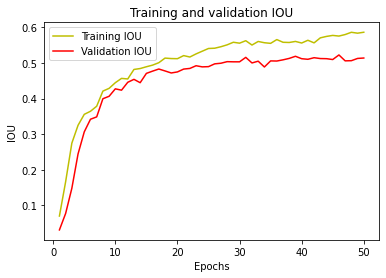

In [18]:
#Fold-1
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

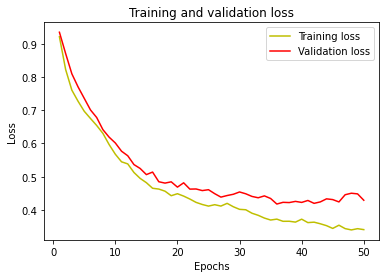

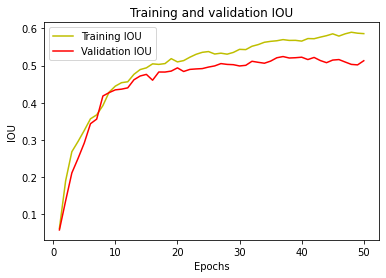

In [18]:
#Fold-2
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

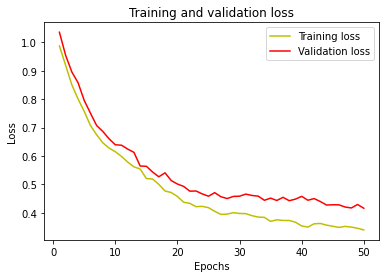

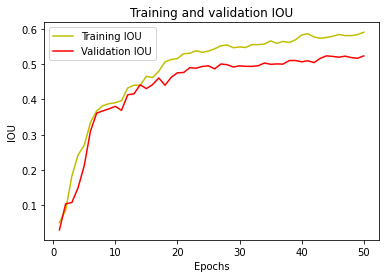

In [18]:
#Fold-3
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

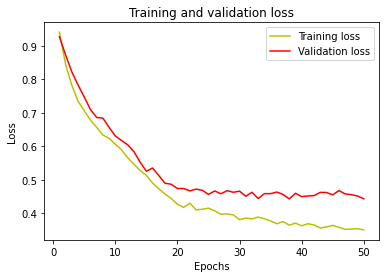

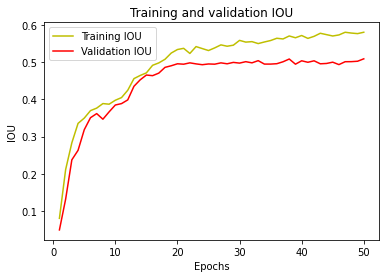

In [18]:
#Fold-4
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

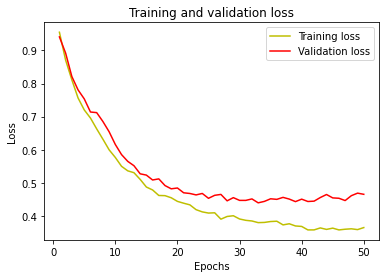

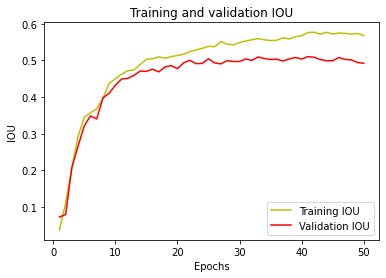

In [18]:
#Fold-5
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Batch 32 - plots

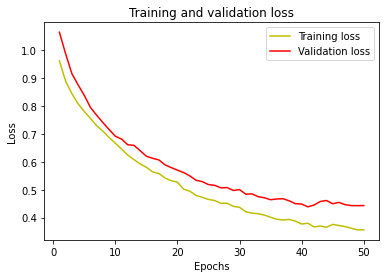

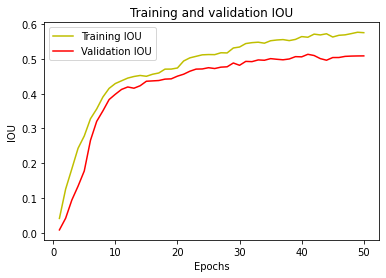

In [18]:
#Fold-1
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

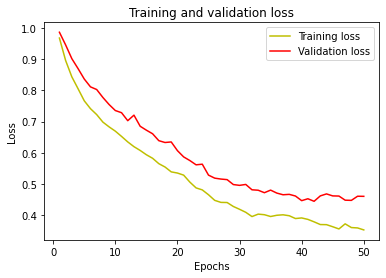

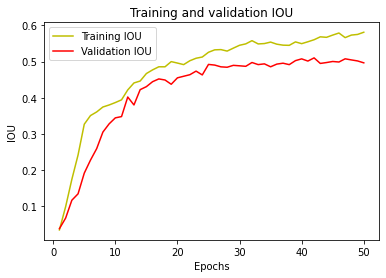

In [18]:
#Fold-2
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

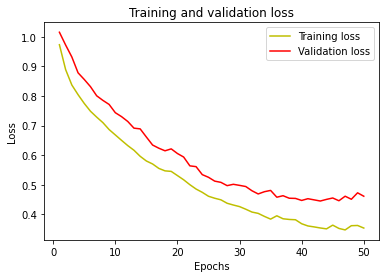

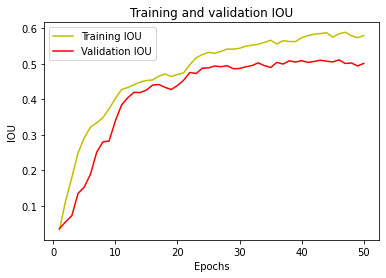

In [18]:
#Fold-3
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

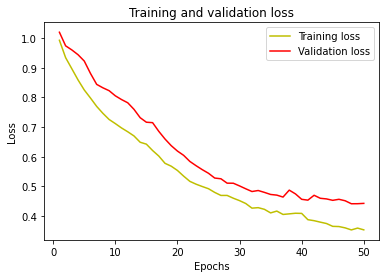

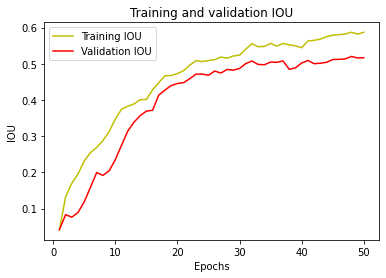

In [18]:
#Fold-4
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

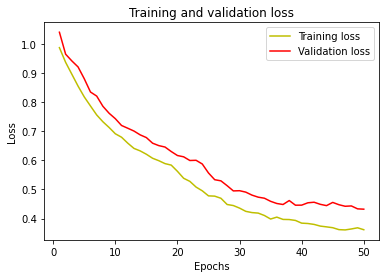

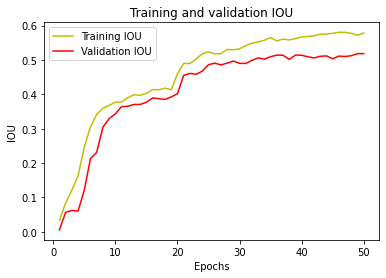

In [19]:
#Fold-5
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [16]:
from keras.models import load_model

#Set compile=False as we are not loading it for training, only for prediction.
#BATCH 8 
model1 = load_model('res34_backbone_50epochs_indoor_f1.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_indoor_f2.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_indoor_f3.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_indoor_f4.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_indoor_f5.hdf5', compile=False)
#BATCH 16
#model1 = load_model('res34_backbone_50epochs_16_indoor_f1.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_16_indoor_f2.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_16_indoor_f3.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_16_indoor_f4.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_16_indoor_f5.hdf5', compile=False)
#BATCH 32
#model1 = load_model('res34_backbone_50epochs_32_indoor_f1.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_32_indoor_f2.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_32_indoor_f3.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_32_indoor_f4.hdf5', compile=False)
#model1 = load_model('res34_backbone_50epochs_32_indoor_f5.hdf5', compile=False)

# Calculating results

In [18]:
#IOU
y_pred1=model1.predict(X_test1)
y_pred1_argmax=np.argmax(y_pred1, axis=3)

In [20]:
n_classes = 10
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5226151


In [21]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

[[1.152812e+06 2.780800e+04 0.000000e+00 2.420000e+02 1.170000e+02
  7.600000e+01 4.700000e+01 5.340000e+02 3.720000e+02 5.666600e+04]
 [1.197300e+04 8.364350e+05 9.200000e+01 3.800000e+02 1.280000e+02
  4.710000e+02 3.500000e+01 6.600000e+01 5.900000e+01 1.720000e+02]
 [2.090000e+03 1.570000e+03 9.550000e+02 3.060000e+02 2.730000e+02
  2.660000e+02 7.500000e+01 7.500000e+01 7.600000e+01 2.020000e+02]
 [2.094000e+03 9.470000e+02 0.000000e+00 8.630000e+02 5.770000e+02
  3.520000e+02 1.040000e+02 1.950000e+02 1.600000e+02 4.850000e+02]
 [1.710000e+03 7.180000e+02 0.000000e+00 2.750000e+02 7.892000e+03
  5.940000e+02 1.660000e+02 1.060000e+02 1.810000e+02 3.740000e+02]
 [2.009000e+03 2.150000e+02 0.000000e+00 1.160000e+02 0.000000e+00
  1.285000e+03 3.810000e+02 6.060000e+02 1.570000e+02 8.350000e+02]
 [2.162000e+03 1.960000e+02 1.000000e+00 2.600000e+01 0.000000e+00
  8.480000e+02 1.186400e+04 1.036000e+03 2.160000e+02 1.104000e+03]
 [2.096000e+03 1.050000e+02 0.000000e+00 2.000000e+00 0

In [22]:
class1_IoU  = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] + values[0,6] + values[0,7] + values[0,8] + values[0,9] + values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0] + values[6,0] + values[7,0] + values[8,0] + values[9,0])
class2_IoU  = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] + values[1,6] + values[1,7] + values[1,8] + values[1,9] + values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1] + values[6,1] + values[7,1] + values[8,1] + values[9,1])
class3_IoU  = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] + values[2,6] + values[2,7] + values[2,8] + values[2,9] + values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2] + values[6,2] + values[7,2] + values[8,2] + values[9,2])
class4_IoU  = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] + values[3,6] + values[3,7] + values[3,8] + values[3,9] + values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3] + values[6,3] + values[7,3] + values[8,3] + values[9,3])
class5_IoU  = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] + values[4,6] + values[4,7] + values[4,8] + values[4,9] + values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4] + values[6,4] + values[7,4] + values[8,4] + values[9,4])
class6_IoU  = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] + values[5,6] + values[5,7] + values[5,8] + values[5,9] + values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5] + values[6,5] + values[7,5] + values[8,5] + values[9,5])
class7_IoU  = values[6,6]/(values[6,6] + values[6,0] + values[6,1] + values[6,2] + values[6,3] + values[6,4] + values[6,5] + values[6,7] + values[6,8] + values[6,9] + values[0,6] + values[1,6] + values[2,6] + values[3,6] + values[4,6] + values[5,6] + values[7,6] + values[8,6] + values[9,6])
class8_IoU  = values[7,7]/(values[7,7] + values[7,0] + values[7,1] + values[7,2] + values[7,3] + values[7,4] + values[7,5] + values[7,6] + values[7,8] + values[7,9] + values[0,7] + values[1,7] + values[2,7] + values[3,7] + values[4,7] + values[5,7] + values[6,7] + values[8,7] + values[9,7])
class9_IoU  = values[8,8]/(values[8,8] + values[8,0] + values[8,1] + values[8,2] + values[8,3] + values[8,4] + values[8,5] + values[8,6] + values[8,7] + values[8,9] + values[0,8] + values[1,8] + values[2,8] + values[3,8] + values[4,8] + values[5,8] + values[6,8] + values[7,8] + values[9,8])
class10_IoU = values[9,9]/(values[9,9] + values[9,0] + values[9,1] + values[9,2] + values[9,3] + values[9,4] + values[9,5] + values[9,6] + values[9,7] + values[9,8] + values[0,9] + values[1,9] + values[2,9] + values[3,9] + values[4,9] + values[5,9] + values[6,9] + values[7,9] + values[8,9])

In [23]:
print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)
print("IoU for class6 is: ", class6_IoU)
print("IoU for class7 is: ", class7_IoU)
print("IoU for class8 is: ", class8_IoU)
print("IoU for class9 is: ", class9_IoU)
print("IoU for class10 is: ", class10_IoU)

IoU for class1 is:  0.8611744
IoU for class2 is:  0.9486606
IoU for class3 is:  0.15967229
IoU for class4 is:  0.12105484
IoU for class5 is:  0.6019373
IoU for class6 is:  0.14565858
IoU for class7 is:  0.64063936
IoU for class8 is:  0.20751026
IoU for class9 is:  0.8909269
IoU for class10 is:  0.64891624


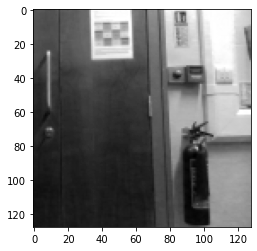

In [24]:
#Varify the prediction on first image
plt.imshow(train_images[0, :,:,0], cmap='gray')

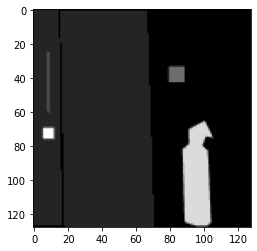

In [25]:
plt.imshow(train_masks[0], cmap='gray')

# Batch 8 - test

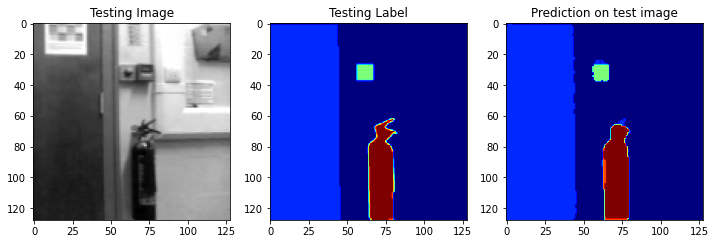

In [24]:
#Fold-1
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

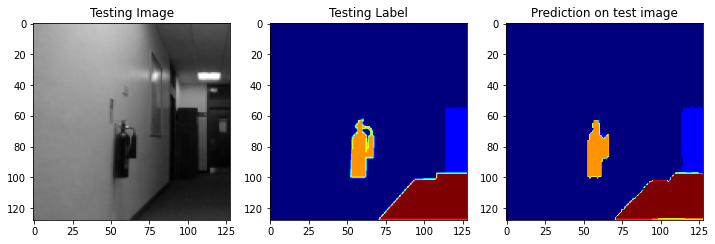

In [23]:
#Fold-2
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

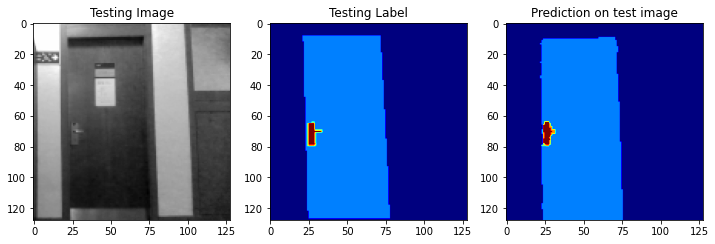

In [25]:
#Fold-3
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

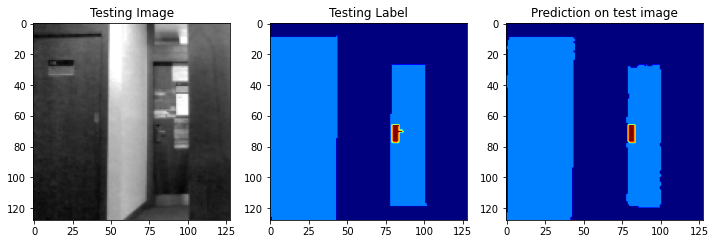

In [25]:
#Fold-4
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

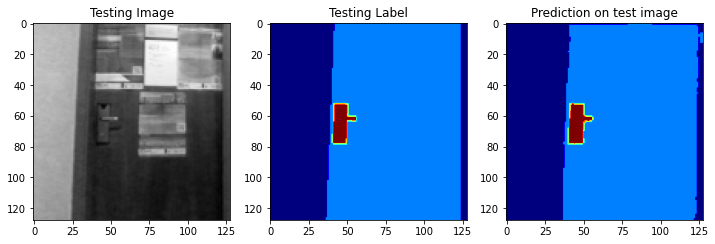

In [24]:
#Fold-5
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

# Batch 16 - test

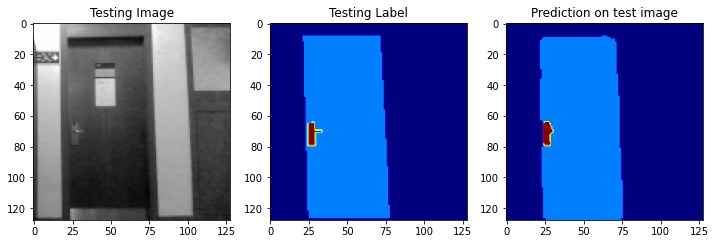

In [24]:
#Fold-1
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

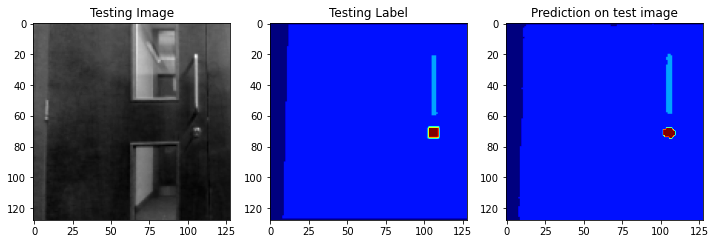

In [25]:
#Fold-2
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

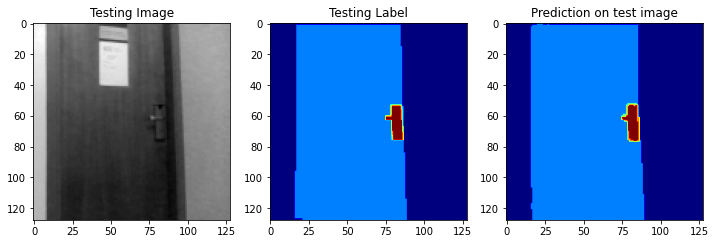

In [24]:
#Fold-3
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

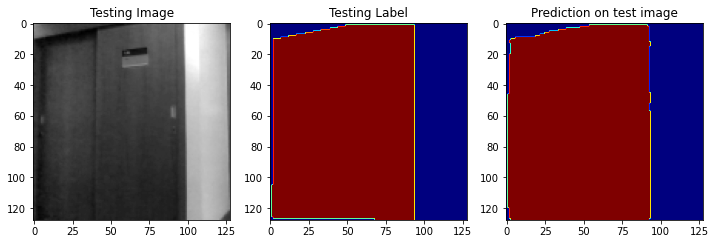

In [24]:
#Fold-4
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

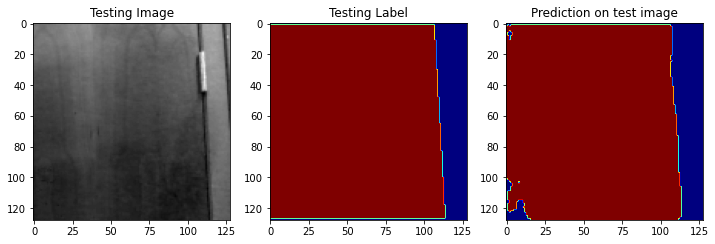

In [24]:
#Fold-5
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

# Batch 32 - test

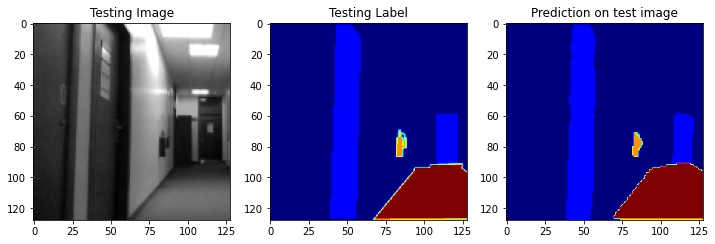

In [24]:
#Fold-1
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

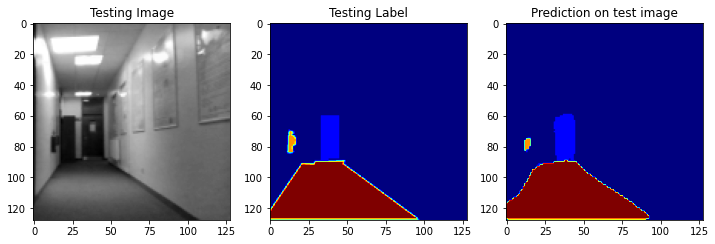

In [24]:
#Fold-2
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

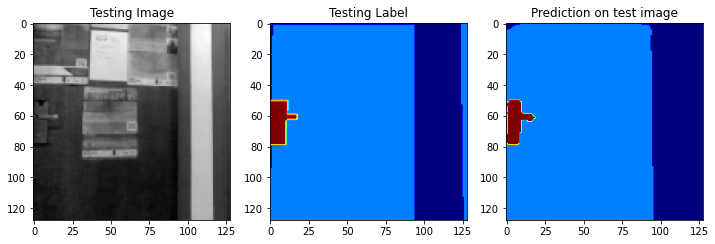

In [26]:
#Fold-3
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

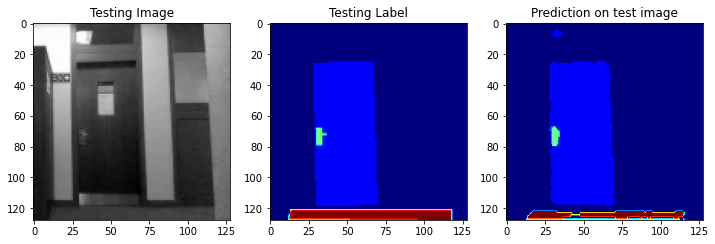

In [26]:
#Fold-4
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()

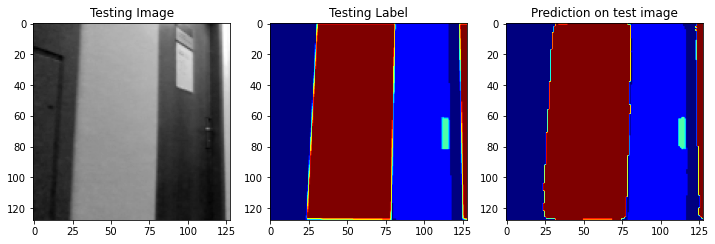

In [24]:
#Fold-5
#Test some random images
import random
test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='jet')
plt.show()